# Import Libraries

In [1]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras 
from keras.layers import Dense, Input, Embedding, LSTM, Dropout, BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import string

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [3]:
df_train = pd.read_csv('twitter_training.csv', header=None, names=['Tweet_Id','Entity','Sentiment','Tweet content'])
print('Size of training dataset: {}' .format(df_train.shape))
df_train.head()

Size of training dataset: (74682, 4)


,Tweet_Id,Entity,Sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
df_test = pd.read_csv('twitter_validation.csv', header=None, names=['Tweet_Id','Entity','Sentiment','Tweet content'])
print('Size of testing dataset: {}' .format(df_test.shape))
df_test.head()

Size of testing dataset: (1000, 4)


,Tweet_Id,Entity,Sentiment,Tweet content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


# EDA

In [5]:
# Training dataset information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_Id       74682 non-null  int64 
 1   Entity         74682 non-null  object
 2   Sentiment      74682 non-null  object
 3   Tweet content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [6]:
# Testing dataset information
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_Id       1000 non-null   int64 
 1   Entity         1000 non-null   object
 2   Sentiment      1000 non-null   object
 3   Tweet content  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


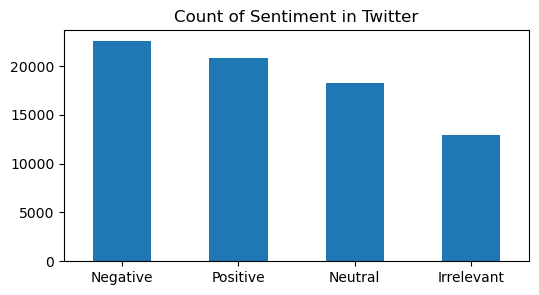

In [7]:
# Count of Sentiment
df_train['Sentiment'].value_counts().plot(kind='bar', title='Count of Sentiment in Twitter', figsize=(6,3))
plt.xticks(rotation=0)
plt.show()

# Data Preprocessing

In [8]:
# Drop rows with Null value
df_train = df_train.dropna()
df_test = df_test.dropna()

In [9]:
def evaluate_metrics(y_test, yhat):
    metrics = {}
    metrics['Accuracy'] = round(accuracy_score(y_test, yhat), 3)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, yhat)
    metrics['Precision'] = round(np.mean(precision),3)
    metrics['Recall'] = round(np.mean(recall),3)
    metrics['F1'] = round(np.mean(f1_score),3)
    
    return metrics

In [10]:
# Define some function to help in remove punctuation, stopwords and lemmatize the words in the text.
def remove_punctuation(text):
    for punc in string.punctuation:
        if punc in text:
             text = text.replace(punc,' ')
    return text.strip().lower()

def remove_stopword(text):
    text = ' '.join([x for x in text.split() if x not in stopwords.words('english')])
    return text

def lemmatize(text):
    text = nltk.word_tokenize(text)
    text = [nltk.WordNetLemmatizer().lemmatize(x) for x in text]
    text = " ".join(text)
    return text

In [11]:
# Define function to present confusion matrix
def plot_graph(y_test, yhat, labels, title):
    sns.set_style('white')
    sns.set_context('notebook')
    cm = confusion_matrix(y_test, yhat)
    plt.figure(figsize=(6,4))
    graph = sns.heatmap(cm,fmt='d', annot=True, linewidth=1, vmin=0, vmax=300)
    graph.set(xlabel = 'Predicted', ylabel='Actual', title='Confusion Matrix for {} Model'.format(title))
    graph.set_yticklabels(labels)
    graph.set_xticklabels(labels)
    plt.show()
    return graph


# Sentiment Analysis using Few Approaches

### 1. Bag of Word Vectorization-based Model

In [12]:
# Change Tweet Content column in training sets
df_train_clean = pd.DataFrame()
df_train_clean['Tweet content'] = df_train['Tweet content'].apply(remove_punctuation)
df_train_clean['Tweet content'] = df_train_clean['Tweet content'].apply(remove_stopword)
df_train_clean['Tweet content'] = df_train_clean['Tweet content'].apply(lemmatize)
df_train_clean.head()

,Tweet content
0,im getting borderland murder
1,coming border kill
2,im getting borderland kill
3,im coming borderland murder
4,im getting borderland 2 murder


In [13]:
# Change Tweet Content column in testing sets
df_test_clean = pd.DataFrame()
df_test_clean['Tweet content'] = df_test['Tweet content'].apply(remove_punctuation)
df_test_clean['Tweet content'] = df_test_clean['Tweet content'].apply(remove_stopword)
df_test_clean['Tweet content'] = df_test_clean['Tweet content'].apply(lemmatize)
df_test_clean.head()

,Tweet content
0,mentioned facebook struggling motivation go ru...
1,bbc news amazon bos jeff bezos reject claim co...
2,microsoft pay word function poorly samsungus c...
3,csgo matchmaking full closet hacking truly awf...
4,president slapping american face really commit...


In [14]:
# Split data into X and y
X_train_bow = df_train_clean['Tweet content']
X_test_bow = df_test_clean['Tweet content']
y_train = df_train['Sentiment']
y_test = df_test['Sentiment']

tfidf = TfidfVectorizer().fit(X_train_bow)
X_train_bow = tfidf.transform(X_train_bow)
X_test_bow = tfidf.transform(X_test_bow)

In [15]:
# Train machine learning using Logistic Regression algorithms
lr = LogisticRegression(n_jobs=-1)

lr.fit(X_train_bow,y_train)
yhat_lr = lr.predict(X_test_bow)

# Show evaluation metrics
score_bow = evaluate_metrics(y_test, yhat_lr)
score_bow

{'Accuracy': 0.908, 'Precision': 0.908, 'Recall': 0.907, 'F1': 0.907}

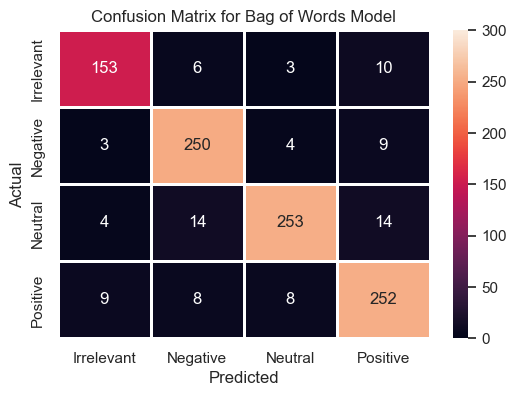

<AxesSubplot:title={'center':'Confusion Matrix for Bag of Words Model'}, xlabel='Predicted', ylabel='Actual'>

In [16]:
lr_labels = lr.classes_
    
plot_graph(y_test, yhat_lr, lr_labels, "Bag of Words")

### 2. LSTM-based Model Approach

In [17]:
# Data preprocessing for LSTM
X_train_LSTM = df_train_clean['Tweet content']
X_test_LSTM = df_test_clean['Tweet content']
y_train = df_train['Sentiment']
y_test = df_test["Sentiment"]

tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(X_train_LSTM.values)

X_train_LSTM = tokenizer.texts_to_sequences(X_train_LSTM)
X_test_LSTM = tokenizer.texts_to_sequences(X_test_LSTM)

X_train_LSTM = pad_sequences(X_train_LSTM, maxlen=50)
X_test_LSTM = pad_sequences(X_test_LSTM, maxlen=50)

# Change categorical label into numerical label, then into sparse matrix
le = LabelEncoder().fit(y_train)
y_train_LSTM = le.transform(y_train)
y_train_LSTM = to_categorical(y_train_LSTM)
y_test_LSTM = le.transform(y_test)

In [18]:
# Form LSTM neural network
model_input = Input(shape=(50,))
x = Embedding(input_dim=500, output_dim=100)(model_input)
x = LSTM(units=100)(x)
x = Dropout(0.2)(x)
x = Dense(units=256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(units=64, activation='relu')(x)
x = BatchNormalization()(x)
model_output = Dense(units=4, activation='softmax')(x)

model = keras.Model(model_input, model_output)

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')
model.fit(X_train_LSTM, y_train_LSTM, validation_split=0.2, epochs=50, batch_size=500)

Epoch 1/50
119/119 [==============================] - 38s 269ms/step - loss: 1.1836 - acc: 0.4840 - val_loss: 1.3405 - val_acc: 0.3838
Epoch 2/50
119/119 [==============================] - 31s 261ms/step - loss: 1.0133 - acc: 0.5708 - val_loss: 1.2992 - val_acc: 0.4216
Epoch 3/50
119/119 [==============================] - 33s 275ms/step - loss: 0.9461 - acc: 0.6023 - val_loss: 1.2876 - val_acc: 0.4325
Epoch 4/50
119/119 [==============================] - 36s 299ms/step - loss: 0.8840 - acc: 0.6319 - val_loss: 1.2937 - val_acc: 0.4362
Epoch 5/50
119/119 [==============================] - 32s 272ms/step - loss: 0.8359 - acc: 0.6519 - val_loss: 1.2505 - val_acc: 0.4722
Epoch 6/50
119/119 [==============================] - 32s 268ms/step - loss: 0.7794 - acc: 0.6786 - val_loss: 1.4143 - val_acc: 0.4213
Epoch 7/50
119/119 [==============================] - 34s 284ms/step - loss: 0.7370 - acc: 0.6993 - val_loss: 1.5008 - val_acc: 0.4521
Epoch 8/50
119/119 [==============================] - 3

In [20]:
yhat_LSTM = [np.argmax(x) for x in model.predict(X_test_LSTM)]
score_LSTM = evaluate_metrics(y_test_LSTM, yhat_LSTM)
score_LSTM

32/32 [==============================] - 4s 12ms/step


{'Accuracy': 0.784, 'Precision': 0.776, 'Recall': 0.78, 'F1': 0.777}

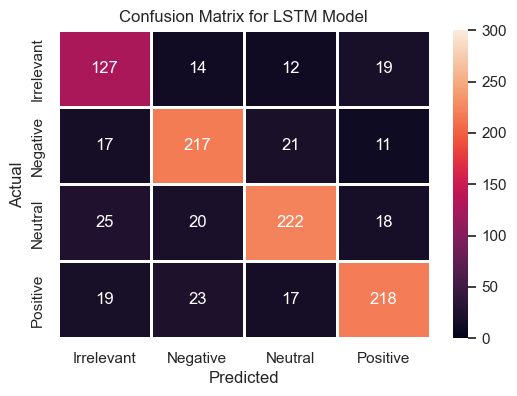

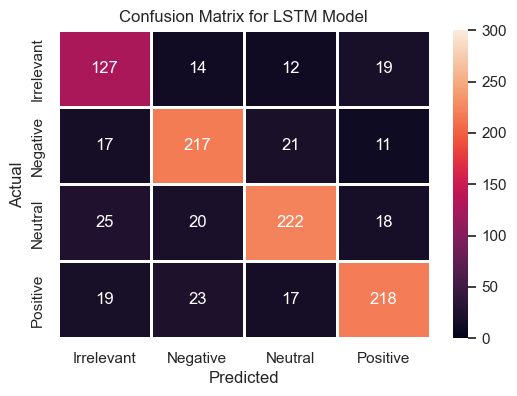

<AxesSubplot:title={'center':'Confusion Matrix for LSTM Model'}, xlabel='Predicted', ylabel='Actual'>

In [21]:
LSTM_labels = le.classes_
plot_graph(y_test_LSTM, yhat_LSTM, LSTM_labels, 'LSTM')

### 3. Transformers-based Model

In [22]:
# Data preprocessing for Transformer Model
# Transformer model only detect Positive and Negative sentiment, hence we remove the Irrelevant and Neutral Sentiment
df_test_trans = df_test[df_test['Sentiment'].isin(['Positive','Negative'])]
X_test_trans = df_test_trans['Tweet content'].values
y_test_trans = df_test_trans['Sentiment']

In [23]:
# Get y_prediction from sentiment pipeline from Transformer Library
from transformers import pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

yhat_test_trans = sentiment_pipeline([x for x in X_test_trans])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceCla

In [24]:
a = []
for x in yhat_test_trans:
    a.append(x['label'].title())
a[:5]

['Negative', 'Negative', 'Negative', 'Positive', 'Positive']

{'Accuracy': 0.807, 'Precision': 0.826, 'Recall': 0.809, 'F1': 0.805}


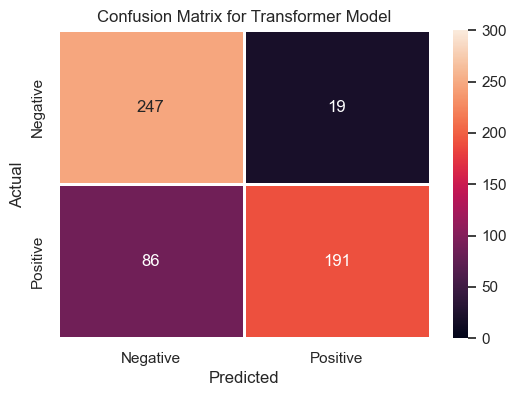

<AxesSubplot:title={'center':'Confusion Matrix for Transformer Model'}, xlabel='Predicted', ylabel='Actual'>

In [31]:
score_trans = evaluate_metrics(y_test_trans,a)
print(score_trans)

plot_graph(y_test_trans, a,['Negative', 'Positive'], "Transformer")

### 4. Sentiment Intensity Analysis-based Model

In [32]:
# Import Sentiment Intensity Analyzer from nltk
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Data preprocessing for SIA model
# SIA model only detect Positive and Negative sentiment, hence we remove the Irrelevant and Neutral Sentiment
df_test_sia = df_test_clean.copy()
df_test_sia['Sentiment'] = df_test['Sentiment']
df_test_sia = df_test_sia[df_test_sia['Sentiment'].isin (['Positive','Negative'])]

X_test_sia = df_test_sia['Tweet content']
y_test_sia = df_test_sia['Sentiment']

In [33]:
# Define a dict and list to extract the information from the SIA model prediction
trans_dict = {}
trans_list = []
for x in X_test_sia:
    s = sia.polarity_scores(x)
    for i in range(len(X_test_sia)):
        trans_dict['Negative'] = s['neg']
        trans_dict['Positive'] = s['pos']
    trans_list.append(max(trans_dict.items(), key=lambda x:x[1])[0])
    
trans_list[:5]

['Negative', 'Negative', 'Positive', 'Positive', 'Positive']

{'Accuracy': 0.724, 'Precision': 0.724, 'Recall': 0.723, 'F1': 0.723}


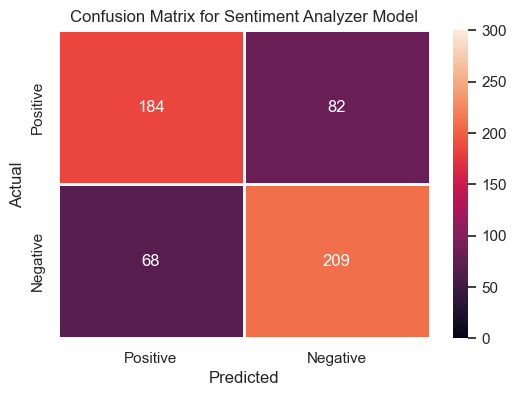

<AxesSubplot:title={'center':'Confusion Matrix for Sentiment Analyzer Model'}, xlabel='Predicted', ylabel='Actual'>

In [34]:
score_sia = evaluate_metrics(y_test_sia, trans_list)
print(score_sia)
plot_graph(y_test_sia, trans_list,['Positive','Negative'], 'Sentiment Analyzer')

# Overall Scores

In [35]:
pd.DataFrame([score_bow, score_LSTM, score_trans, score_sia], 
             index=['Bag of Words','LSTM','Transformer','Sentiment Intensity Analyzer'])

,Accuracy,Precision,Recall,F1
Bag of Words,0.908,0.908,0.907,0.907
LSTM,0.784,0.776,0.780,0.777
Transformer,0.807,0.826,0.809,0.805
Sentiment Intensity Analyzer,0.724,0.724,0.723,0.723
